In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

all_ts = ma.vstack(tseries_w)

f = h5py.File('../data/symbol_seq_sims/symbol_sequence_simulations.h5','r')
sims_w = []
for worm in range(len(tseries_w)):
    sims_w.append(np.array(f[str(worm)]['sims'],dtype=int))
f.close()

In [3]:
eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])

In [4]:
n_clusters=1000
f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()
labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked


In [5]:
n_worms = len(tseries_w)
len_w = len(tseries_w[0])

In [6]:
labels_w = labels_traj.reshape((n_worms,len_w))

In [7]:
n_sims=1000
dim = tseries_w[0].shape[1]
lags_acf = np.array(np.arange(0,10*frameRate,1),dtype=int)
acfs_data_w = np.zeros((len(tseries_w),len(lags_acf),dim))
acfs_sims_w = np.zeros((len(tseries_w),n_sims,len(lags_acf),dim))
acfs_shuffled_sims_w = np.zeros((len(tseries_w),n_sims,len(lags_acf),dim))
for kw in range(len(tseries_w)):
    f = h5py.File("../data/acfs/acfs_{}.h5".format(kw),'r')
    acfs_data_w[kw,:,:] = np.array(f['acfs_data'])
    acfs_sims_w[kw,:,:,:] = np.array(f['acfs_sims'])
    acfs_shuffled_sims_w[kw,:,:,:] = np.array(f['acfs_shuffled_sims'])
    f.close()

In [8]:
def bootstrap(l,n_times,confidence_interval=95,n_samples=None,median=False,maximum=False,log=False):
    if n_samples==None:
        n_samples = len(l)
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.randint(0,len(l),n_samples)
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.mean(l,axis=0),cil,ciu

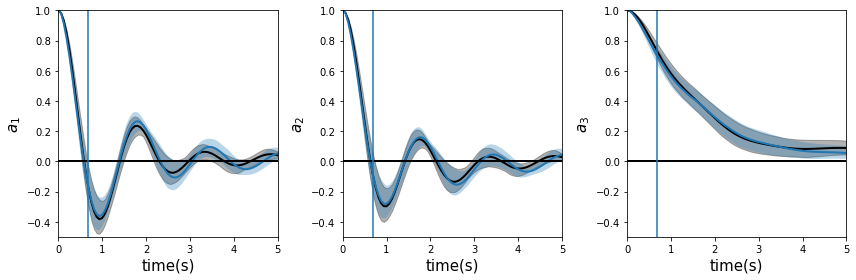

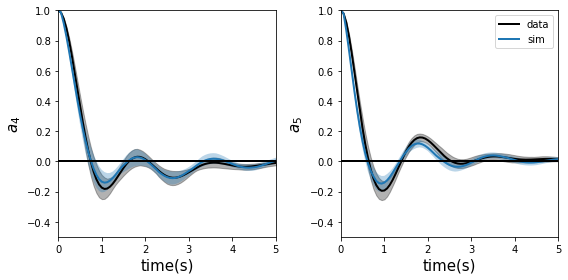

In [10]:
plt.figure(figsize=(12,4))
for kd in range(3):
    plt.subplot(1,3,kd+1)
    mean,cil,ciu = bootstrap(acfs_data_w[:,:,kd],n_times=1000)
    plt.plot(lags_acf*dt,mean,lw=2,c='k')
    plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3,color='k')
    mean,cil,ciu = bootstrap(np.concatenate(acfs_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
    plt.plot(lags_acf*dt,mean,lw=2)
    plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3)
#     mean,cil,ciu = bootstrap(np.concatenate(acfs_shuffled_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
#     plt.plot(lags_acf*dt,mean,lw=3,alpha=.5)
#     plt.fill_between(lags_acf*dt,cil,ciu,alpha=.2)
    plt.axhline(0,c='k',lw=2)
    plt.xlim(0,5)
    plt.ylim(-.5,1)
    plt.ylabel('$a_{}$'.format(kd+1),fontsize=15)
    plt.xlabel('time(s)',fontsize=15)
    plt.axvline(11*dt)

plt.tight_layout()
# plt.savefig('acfs_sims_1-3.pdf')
plt.show()
plt.figure(figsize=(8,4))
kd=kd+1
plt.subplot(1,2,1)
mean,cil,ciu = bootstrap(acfs_data_w[:,:,kd],n_times=1000)
plt.plot(lags_acf*dt,mean,lw=2,c='k')
plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3,color='k')
mean,cil,ciu = bootstrap(np.concatenate(acfs_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
plt.plot(lags_acf*dt,mean,lw=2)
plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3)
# mean,cil,ciu = bootstrap(np.concatenate(acfs_shuffled_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
# plt.plot(lags_acf*dt,mean,lw=3,alpha=.5)
# plt.fill_between(lags_acf*dt,cil,ciu,alpha=.2)
# plt.fill_between(lags_acf*dt,cil,ciu,alpha=.2)
plt.axhline(0,c='k',lw=2)
plt.xlim(0,5)
plt.ylim(-.5,1)
plt.ylabel('$a_{}$'.format(kd+1),fontsize=15)
plt.xlabel('time(s)',fontsize=15)
kd=kd+1
plt.subplot(1,2,2)
mean,cil,ciu = bootstrap(acfs_data_w[:,:,kd],n_times=1000)
plt.plot(lags_acf*dt,mean,lw=2,c='k',label='data')
plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3,color='k')
mean,cil,ciu = bootstrap(np.concatenate(acfs_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
plt.plot(lags_acf*dt,mean,lw=2,label='sim')
plt.fill_between(lags_acf*dt,cil,ciu,alpha=.3)
# mean,cil,ciu = bootstrap(np.concatenate(acfs_shuffled_sims_w[:,:,:,kd],axis=0),n_times=1000,n_samples = len(tseries_w))
# plt.plot(lags_acf*dt,mean,lw=3,alpha=.5,label='shuffle')
# plt.fill_between(lags_acf*dt,cil,ciu,alpha=.2)
plt.axhline(0,c='k',lw=2)
plt.xlim(0,5)
plt.ylim(-.5,1)
plt.legend()
plt.ylabel('$a_{}$'.format(kd+1),fontsize=15)
plt.xlabel('time(s)',fontsize=15)
plt.tight_layout()
# plt.savefig('acfs_sims_4-5.pdf')
plt.show()

# Event rates

In [11]:
n_sims=1000

dorsal_turn_rate_data_w = np.zeros((n_worms,3))
dorsal_turn_rate_sims_w = np.zeros((n_worms,n_sims,3))
ventral_turn_rate_data_w = np.zeros((n_worms,3))
ventral_turn_rate_sims_w = np.zeros((n_worms,n_sims,3))
rev_rate_data_w = np.zeros((n_worms,3))
rev_rate_sims_w = np.zeros((n_worms,n_sims,3))

for kw in range(n_worms):
    f = h5py.File('../data/sim_event_rates/rates_{}.h5'.format(kw),'r') 
    rev_rate_data_w[kw] = np.array(f['rev_rate_data'])
    ventral_turn_rate_data_w[kw] = np.array(f['ventral_turn_rate_data'])
    dorsal_turn_rate_data_w[kw] = np.array(f['dorsal_turn_rate_data'])
    rev_rate_sims_w[kw] = np.array(f['rev_rate_sims'])
    ventral_turn_rate_sims_w[kw] = np.array(f['ventral_turn_rate_sims'])
    dorsal_turn_rate_sims_w[kw] = np.array(f['dorsal_turn_rate_sims'])
    f.close()

In [12]:
colors_states_ = ['#009FE3','#312783','#1F77B4']
states = ['ventral turns','dorsal turns','reversals']

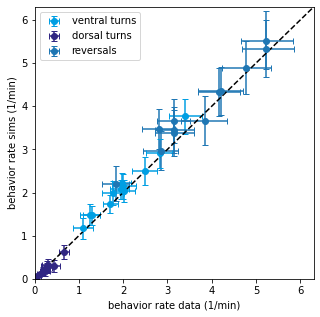

In [13]:
rev_rate_sim_w = rev_rate_sims_w.mean(axis=1)
ventral_turn_rate_sim_w = ventral_turn_rate_sims_w.mean(axis=1)
dorsal_turn_rate_sim_w = dorsal_turn_rate_sims_w.mean(axis=1)
plt.figure(figsize=(5,5))
plt.errorbar(ventral_turn_rate_data_w[:,0],ventral_turn_rate_sim_w[:,0],xerr = [ventral_turn_rate_data_w[:,0]-ventral_turn_rate_data_w[:,1],ventral_turn_rate_data_w[:,2]-ventral_turn_rate_data_w[:,0]],
             yerr = [ventral_turn_rate_sim_w[:,0]-ventral_turn_rate_sim_w[:,1],ventral_turn_rate_sim_w[:,2]-ventral_turn_rate_sim_w[:,0]],fmt='o',capsize=3,label='ventral turns',c=colors_states_[0])
plt.errorbar(dorsal_turn_rate_data_w[:,0],dorsal_turn_rate_sim_w[:,0],xerr = [dorsal_turn_rate_data_w[:,0]-dorsal_turn_rate_data_w[:,1],dorsal_turn_rate_data_w[:,2]-dorsal_turn_rate_data_w[:,0]],
             yerr = [dorsal_turn_rate_sim_w[:,0]-dorsal_turn_rate_sim_w[:,1],dorsal_turn_rate_sim_w[:,2]-dorsal_turn_rate_sim_w[:,0]],fmt='o',capsize=3,label='dorsal turns',c=colors_states_[1])
plt.errorbar(rev_rate_data_w[:,0],rev_rate_sim_w[:,0],xerr = [rev_rate_data_w[:,0]-rev_rate_data_w[:,1],rev_rate_data_w[:,2]-rev_rate_data_w[:,0]],
             yerr = [rev_rate_sim_w[:,0]-rev_rate_sim_w[:,1],rev_rate_sim_w[:,2]-rev_rate_sim_w[:,0]],fmt='o',capsize=3,label='reversals',c=colors_states_[2])
plt.plot(np.arange(10),np.arange(10),c='k',ls='--')
plt.xlim(0,6.3)
plt.ylim(0,6.3)
plt.legend()
plt.xlabel('behavior rate data (1/min)')
plt.ylabel('behavior rate sims (1/min)')
# plt.savefig('behavior_rate_data_vs_sims.pdf')
plt.show()

# runs pirouettes

In [14]:
n_clusters=1000
frameRate=16.
dt=1/frameRate

f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'],dtype=int)
f.close()

eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

In [15]:
worms = np.arange(12)
len_w = 33600
ensemble_labels_w=[]
for worm in worms:
    ensemble_labels_w.append(labels_traj[len_w*worm:len_w*(worm+1)])

In [16]:
sims_w = []
f = h5py.File('../data/symbol_seq_sims/symbol_sequence_simulations.h5','r')
for worm in worms:
    sims = np.array(f['{}/sims'.format(worm)],dtype=int)
    sims_w.append(sims)
f.close()

In [17]:
def bootstrap_rates(l,n_times,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return 1/ma.mean(l,axis=0),cil,ciu

In [18]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [19]:
n_states=2

mfpt_data_w = np.zeros((len(worms),2,3))
mfpt_sim_w = np.zeros((len(worms),2,3))
rates_data_w = np.zeros((len(worms),2,3))
rates_sim_w = np.zeros((len(worms),2,3))

for worm in worms:
    labels = ensemble_labels_w[worm]
    sims = sims_w[worm]

    cluster_labels = labels_tree[n_states-2,:]
    sims_lifetimes = [stats.state_lifetime(ma.array(cluster_labels[sim]),delay*dt) for sim in sims]

    cluster_traj = ma.copy(labels)
    cluster_traj[~labels.mask] = ma.array(cluster_labels)[labels[~labels.mask]]
    cluster_traj[labels.mask] = ma.masked

    data_lifetimes = stats.state_lifetime(cluster_traj[::delay],delay*dt)

    for state_idx in range(2):
        mfpt_data_w[worm,state_idx,:] = np.hstack(stats.bootstrap(data_lifetimes[state_idx],n_times=1000))
        rates_data_w[worm,state_idx,:] = np.hstack(bootstrap_rates(data_lifetimes[state_idx],n_times=1000))
        all_sim_means = [np.mean(sims_lifetimes[k][state_idx]) for k in range(len(sims_lifetimes))]
        mfpt_sim_w[worm,state_idx,:] = np.mean(all_sim_means),np.percentile(all_sim_means,2.5),np.percentile(all_sim_means,97.5)
        all_sim_rate_means = [1/np.mean(sims_lifetimes[k][state_idx]) for k in range(len(sims_lifetimes))]
        mean_sim_rate = 1/np.hstack([sims_lifetimes[k][state_idx] for k in range(len(sims_lifetimes))]).mean()
        rates_sim_w[worm,state_idx,:] = mean_sim_rate,np.percentile(all_sim_rate_means,2.5),np.percentile(all_sim_rate_means,97.5)
        
    print(worm)

0
1
2
3
4
5
6
7
8
9
10
11


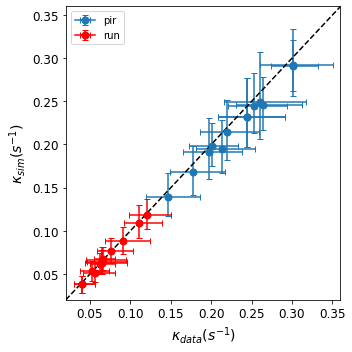

In [20]:
state_idx=0
plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = rates_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = rates_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=3,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=3,marker='o',markersize=7,label='pir')


state_idx=1
# plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = rates_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = rates_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=3,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=3,marker='o',markersize=7,label='run')

xrange=np.linspace(.02,.5,2)
plt.plot(xrange,xrange,c='k',ls='--')
# plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(.02,.36)
plt.ylim(.02,.36)
plt.ylabel(r'$\kappa_{sim}(s^{-1})$',fontsize=14)
plt.xlabel(r'$\kappa_{data}(s^{-1})$',fontsize=14)
plt.legend()
plt.tight_layout()
# plt.savefig('rate_both_states_caps.pdf')
plt.show()

In [21]:
from scipy.io import loadmat
mat = loadmat('../data/Foraging_N2/shapes.mat')
theta_ensemble = np.array(mat['theta_ensemble'],dtype=float)
stepper_to_mm = 788
wormCM = ma.array(mat['wormCm'][:,::2,:],dtype=float)/stepper_to_mm
wormCM[wormCM==0] = ma.masked

In [22]:
cluster_labels = labels_tree[0,:]
cluster_traj = ma.copy(labels_traj)
cluster_traj[~labels_traj.mask] = ma.array(cluster_labels)[labels_traj[~labels_traj.mask]]
cluster_traj[labels_traj.mask] = ma.masked

In [23]:
vmin,vmax=-.02,.05
len_w = len(tseries_w[0])
kw=8
t0 = int(5*frameRate*60)
tf=int(15*frameRate*60)

In [24]:
labels = cluster_traj[kw*len_w:(kw+1)*len_w][t0:tf]

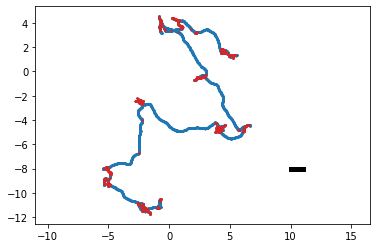

In [25]:
sel = labels==1
plt.scatter(wormCM[kw][t0:tf][sel,0],wormCM[kw][t0:tf][sel,1],c=colors_state_[0],s=1,alpha=1,vmin=-.2,vmax=1.2)
sel = labels==0
plt.scatter(wormCM[kw][t0:tf][sel,0],wormCM[kw][t0:tf][sel,1],c=colors_state_[3],s=1,alpha=1,vmin=-.2,vmax=1.2)
plt.axis('equal')
plt.plot([10,11],[-8,-8],c='k',lw=5)
# plt.savefig('centroid_example_run_pirouette.png',dpi=600)
plt.show()